In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from nltools.data import Brain_Data, Design_Matrix, Adjacency
import networkx as nx
from scipy import signal
from mne_connectivity import spectral_connectivity_epochs
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
from itertools import cycle
from matplotlib.lines import Line2D
from scipy.fft import fft, fftfreq
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from matplotlib.animation import FuncAnimation, PillowWriter
import plotly.graph_objs as go
from functools import reduce
import teneto


from functions.Connectivity import *

In [2]:
patient='S5'
output= "/home/pablo/works/dev_thesis_SEEG/outputs_simil_t03"
ref='x1'


#Reading a npy file 
data_alpha = np.load(f'{output}/{patient}/ref_{ref}/percentile_0.9/{patient}_connectivity_data_alpha_aec_dense.npy')
data_beta = np.load(f'{output}/{patient}/ref_{ref}/percentile_0.9/{patient}_connectivity_data_beta_aec_dense.npy')
data_hgamma = np.load(f'{output}/{patient}/ref_{ref}/percentile_0.9/{patient}_connectivity_data_high_gamma1_aec_dense.npy')
data_lgamma = np.load(f'{output}/{patient}/ref_{ref}/percentile_0.9/{patient}_connectivity_data_low_gamma_aec_dense.npy')
data_theta = np.load(f'{output}/{patient}/ref_{ref}/percentile_0.9/{patient}_connectivity_data_theta_aec_dense.npy')

data_alpha_norm = np.load(f'{output}/{patient}/ref_{ref}/percentile_0.9/{patient}_connectivity_data_alpha_aec_distance_dense.npy')
data_beta_norm = np.load(f'{output}/{patient}/ref_{ref}/percentile_0.9/{patient}_connectivity_data_beta_aec_distance_dense.npy')

data_hgamma_norm = np.load(f'{output}/{patient}/ref_{ref}/percentile_0.9/{patient}_connectivity_data_high_gamma1_aec_distance_dense.npy')
data_lgamma_norm = np.load(f'{output}/{patient}/ref_{ref}/percentile_0.9/{patient}_connectivity_data_low_gamma_aec_distance_dense.npy')
data_theta_norm = np.load(f'{output}/{patient}/ref_{ref}/percentile_0.9/{patient}_connectivity_data_theta_aec_distance_dense.npy')
# Reading the .tsv file 


# Reading the .tsv file 
xyz_loc = pd.read_csv(f'{output}/{patient}/ref_{ref}/percentile_0.9/xyz_loc.csv', sep='\t')

/tmp/ipykernel_1452464/2004170792.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


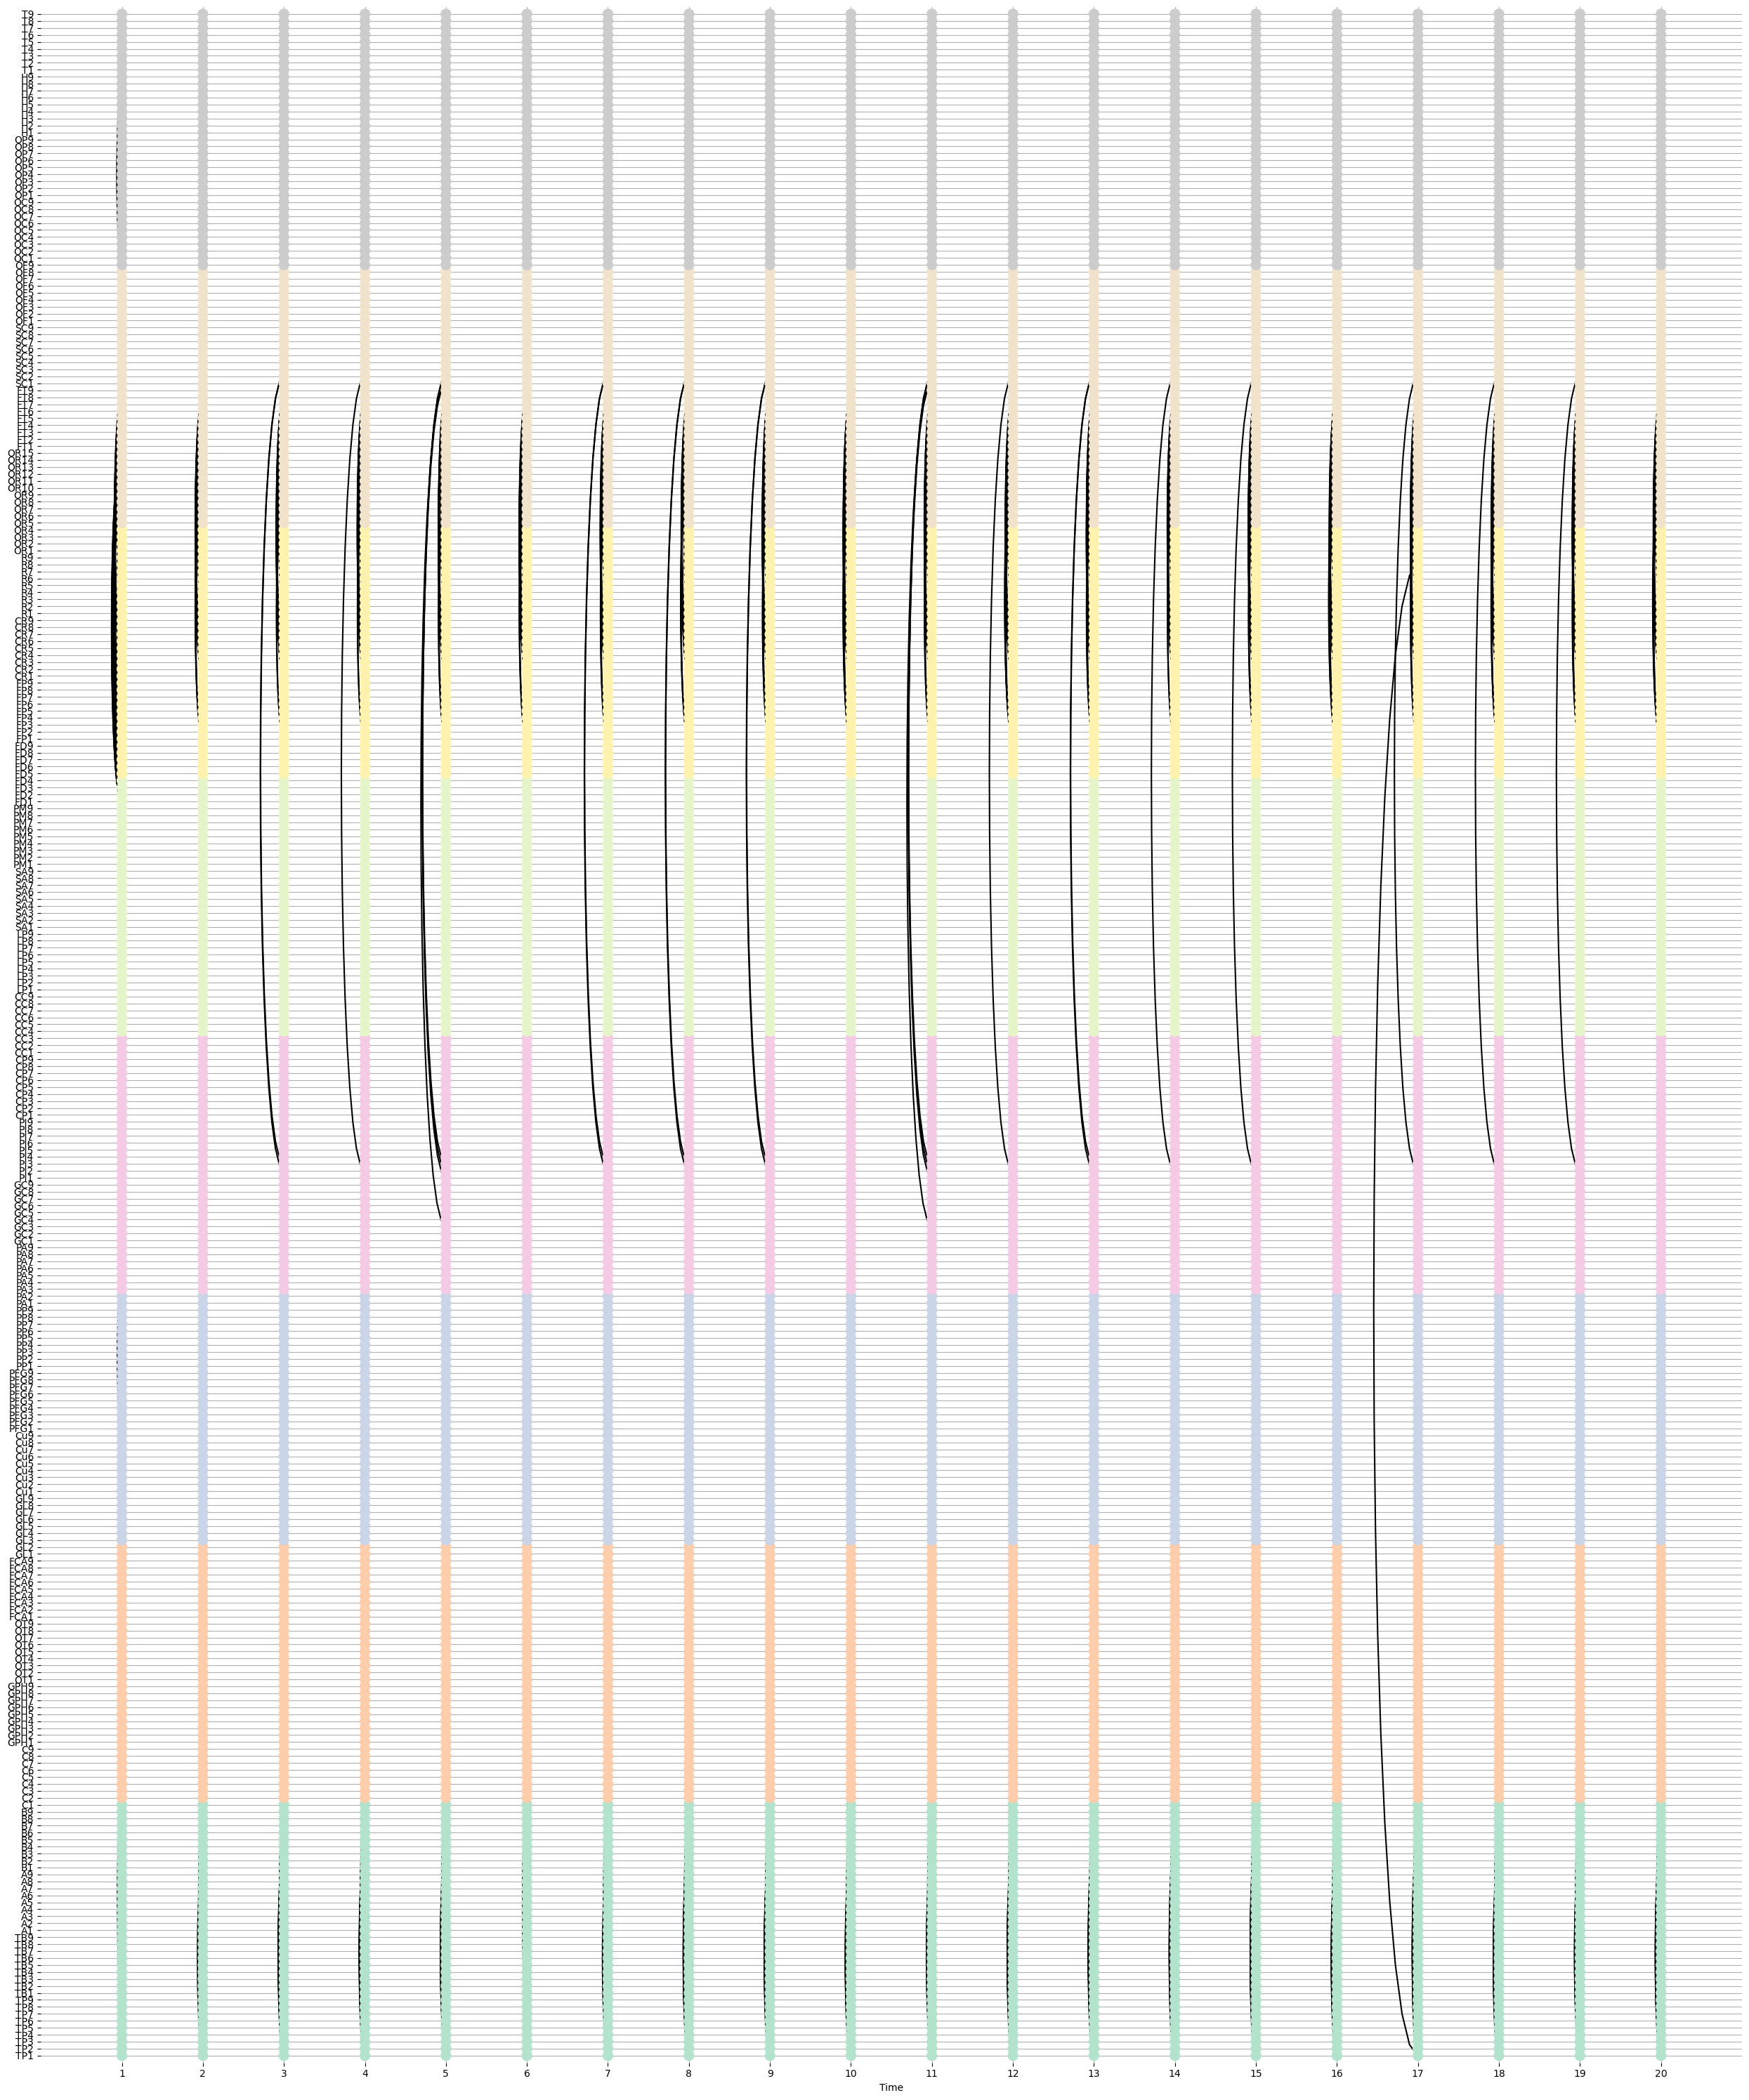

In [7]:
from teneto import TemporalNetwork
#Ploting the graph
from teneto import plot 

data=data_lgamma
#Preparing data node,node,time
data=data.transpose(1,2,0)
tnet_bu= TemporalNetwork(N=data.shape[0],T=data.shape[2],nettype='wu',from_array=data,
                      timetype='discrete',timeunit='epoch', nodelabels=list(xyz_loc['formatted_label'].values))

tnet_bu.binarize(threshold_type='percent',threshold_level=0.01,axis='graphlet')

tnet_wu=TemporalNetwork(N=data.shape[0],T=data.shape[2],nettype='wu',from_array=data,
                      timetype='discrete',timeunit='epoch', nodelabels=list(xyz_loc['formatted_label'].values))



fig,ax = plt.subplots(figsize=(25,30))
ax = plot.slice_plot(tnet_bu.network, ax, plotedgeweights=False,cmap='Pastel2', nodelabels=list(xyz_loc['formatted_label'].values))
plt.tight_layout()
fig.show()

In [8]:
def plot_weight_distribution_with_threshold(data, bins=30, percentile=90):
    """
    Plots the density distribution of edge weights over time and adds a magnitude-based threshold line.

    Parameters
    ----------
    data : 3D numpy array
        Temporal network data in the form (nodes, nodes, time).
    bins : int, optional
        Number of bins for the histogram, by default 30.
    percentile : int, optional
        Percentile for magnitude-based threshold, by default 90 (top 10% of weights).
    """
    num_timepoints = data.shape[2]
    fig, axs = plt.subplots(num_timepoints, 1, figsize=(10, 3 * num_timepoints))
    
    # Check if only one subplot axis is returned
    if num_timepoints == 1:
        axs = [axs]

    thresholds = []

    for t in range(num_timepoints):
        weights = data[:, :, t].flatten()  # Flatten the matrix to get all edge weights
        weights = weights[weights != 0]  # Filter out zero weights if they don't contribute to connectivity


        # Calculate the threshold at the specified percentile for this time point
        threshold_value = np.percentile(weights, percentile)
        thresholds.append(threshold_value)
        
        # Calculate threshold based on the specified percentile
        threshold_value = np.percentile(weights, percentile)

        # Plot histogram and KDE for the weights
        ax = axs[t]
        sns.histplot(weights, bins=bins, kde=True, ax=ax, color="blue", alpha=0.6)
        
        # Add threshold line to plot
        ax.axvline(threshold_value, color='red', linestyle='--', label=f'Threshold ({percentile}th percentile)')
        
        # Set plot labels, title, and legend
        ax.set_title(f'Time Point {t + 1} - Weight Distribution with Threshold')
        ax.set_xlabel('Edge Weight')
        ax.set_ylabel('Density')
        ax.legend()

    plt.tight_layout()
    plt.show()

    # Calculate the mean of all threshold values
    mean_threshold = np.mean(thresholds)

    print(f'Selected threshold value at the {percentile}th percentile is: {threshold_value}')
    print(f"Mean threshold value across time points: {mean_threshold}")


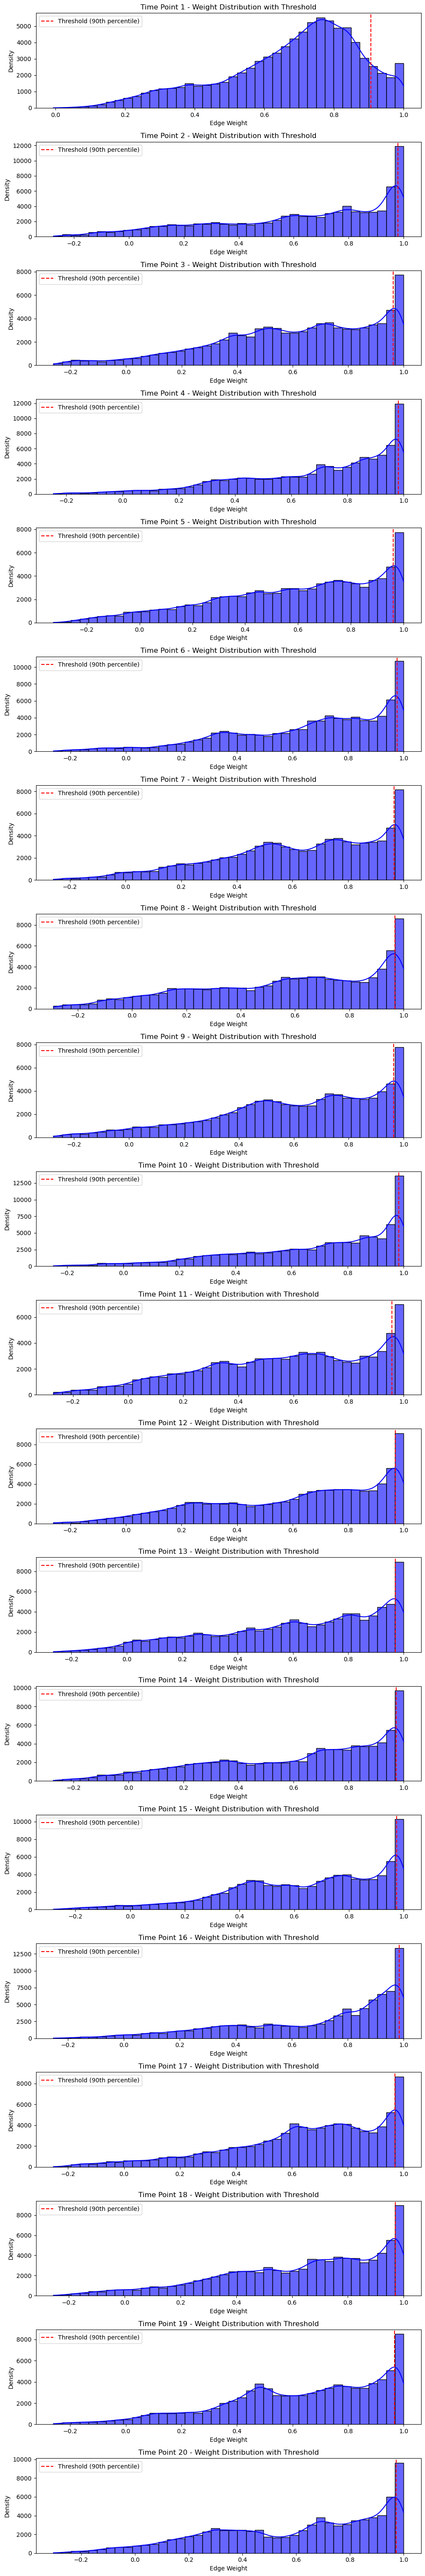

Selected threshold value at the 90th percentile is: 0.9717462092401175
Mean threshold value across time points: 0.9678110329762747


In [9]:
plot_weight_distribution_with_threshold(data, bins=40, percentile=90)

In [ ]:
adj=Adjacency(tnet_bu.network[:,:,6],labels=tnet_bu.nodelabels)
G=nx.Graph(adj.to_graph())

cliques = nx.find_cliques(G)
cliques = [frozenset(c) for c in cliques if len(c) >= 2]
len(cliques)

In [9]:
def calculate_temporal_metrics(data, time_labels=None):
    """
    Calculate and plot temporal graph metrics: node strength, eigen-centrality, betweenness centrality, 
    and clustering coefficient.

    Parameters
    ----------
    data : 3D numpy array
        Temporal network data of shape (nodes, nodes, time).
    time_labels : list, optional
        Labels for time points, defaults to integers starting from 1.

    Returns
    -------
    metrics : dict
        Dictionary containing the temporal evolution of each metric.
    """
    # Initialize storage for metrics
    num_timepoints = data.shape[2]
    metrics = {"Node Strength": [], "Eigen-Centrality": [], 
               "Betweenness Centrality": [], "Clustering Coefficient": []}

    # Iterate through each graph in the temporal array
    for t in range(num_timepoints):
        adjacency_matrix = data[:, :, t]
        G = nx.from_numpy_array(adjacency_matrix)

        # Node Strength (sum of edge weights connected to a node)
        node_strength = np.sum(adjacency_matrix, axis=1)
        avg_node_strength = np.mean(node_strength)
        metrics["Node Strength"].append(avg_node_strength)

        # Eigen-Centrality
        eigen_centrality = nx.eigenvector_centrality_numpy(G)
        avg_eigen_centrality = np.mean(list(eigen_centrality.values()))
        metrics["Eigen-Centrality"].append(avg_eigen_centrality)

        # Betweenness Centrality
        betweenness = nx.betweenness_centrality(G)
        avg_betweenness = np.mean(list(betweenness.values()))
        metrics["Betweenness Centrality"].append(avg_betweenness)

        # Clustering Coefficient
        clustering_coeffs = nx.clustering(G)
        avg_clustering_coeff = np.mean(list(clustering_coeffs.values()))
        metrics["Clustering Coefficient"].append(avg_clustering_coeff)

    # Generate time labels if not provided
    if time_labels is None:
        time_labels = list(range(0, num_timepoints))

    # Plot metrics over time
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    axs = axs.flatten()
    metric_names = list(metrics.keys())

    for i, (metric_name, metric_values) in enumerate(metrics.items()):
        ax = axs[i]
        ax.plot(time_labels, metric_values, marker='o', color='b')
        ax.set_title(metric_name)
        ax.set_xlabel("Time")
        ax.set_ylabel("Average Value")

    plt.tight_layout()
    plt.show()
    
    return metrics


In [ ]:
calculate_temporal_metrics(tnet_bu.network)

### Other important metrics

In [ ]:
from teneto import networkmeasures as nwm
#Centrality measures 
degree_centrality_1=nwm.temporal_degree_centrality(tnet_wu,calc='overtime')
#Plotting the degree centrality
plt.figure(figsize=(10,5))
plt.plot(degree_centrality_1)
plt.title('Degree centrality over time')
plt.xlabel('Channels')
plt.xticks(np.arange(0, len(xyz_loc['formatted_label'].values), 1), xyz_loc['formatted_label'].values, rotation=90)
plt.ylabel('Degree centrality')
plt.show()


degree_centrality_2=nwm.temporal_degree_centrality(tnet_wu,calc='pertime')
#Plot a sns.heamap of the degree centrality
plt.figure(figsize=(10,10))
sns.heatmap(degree_centrality_2, yticklabels=xyz_loc['formatted_label'].values, xticklabels=np.arange(0, data.shape[2], 1))
plt.title('Degree centrality heatmap')
#Size of the yticks

plt.xlabel('Time')
plt.ylabel('Channels')
plt.show()



In [ ]:
#Temporal betweenness centrality
#Network has to be binary

betweenness_centrality_1=nwm.temporal_betweenness_centrality(tnet_bu,calc='overtime')
#Plotting the betweenness centrality


In [ ]:
#Temporal closeness centrality
temporal_closeness_centrality_1=nwm.temporal_closeness_centrality(tnet_bu)

In [ ]:
#Topological overal

In [ ]:
#Bursty coeff
burstiness=nwm.bursty_coeff(tnet_bu,calc='edge')

### Comumnity detection 

In [ ]:
#Lovain clustering
communities=teneto.communitydetection.temporal_louvain(tnet_bu, resolution=1.5,njobs=4,consensus_threshold=0.5)

In [ ]:
#plotting the communities
fig,ax = plt.subplots(figsize=(25,15))
sns.heatmap(communities,cmap='viridis',ax=ax)
plt.title('Communities')
plt.xlabel('Time')

plt.ylabel('Channels')
plt.yticks(np.arange(0, len(xyz_loc['formatted_label'].values), 1), xyz_loc['formatted_label'].values)
plt.show()

#### SubCommunity metrics

In [ ]:
from teneto import communitymeasures
#Community measures
flexibility_m=communitymeasures.flexibility(communities)
plt.figure(figsize=(20,5))
#Plotting the flexibility
sns.barplot(x=xyz_loc['formatted_label'].values, y=flexibility_m)
plt.title('Flexibility')
plt.xlabel('Channels')
plt.ylabel('Flexibility')
plt.xticks(rotation=90)
plt.show()

In [ ]:
allegiance_m=communitymeasures.allegiance(communities)
plt.figure(figsize=(20,20))
sns.heatmap(allegiance_m,cmap='viridis')
plt.title('Allegiance')
plt.xlabel('Channels')
plt.ylabel('Communities')
plt.yticks(np.arange(0, len(xyz_loc['formatted_label'].values), 1), xyz_loc['formatted_label'].values)
plt.xticks(np.arange(0, len(xyz_loc['formatted_label'].values), 1), xyz_loc['formatted_label'].values)
plt.show()

In [ ]:
promiscuity_m=communitymeasures.promiscuity(communities)
plt.figure(figsize=(20,5))
sns.barplot(x=xyz_loc['formatted_label'].values, y=promiscuity_m)
plt.title('Promiscuity')
plt.xlabel('Channels')
plt.ylabel('Promiscuity')
plt.xticks(rotation=90)
plt.show()

In [13]:
persistence_mg=communitymeasures.persistence(communities,calc='global')
persistence_mt=communitymeasures.persistence(communities,calc='time')
persistence_mn=communitymeasures.persistence(communities,calc='node')

In [ ]:
plt.figure(figsize=(20,5))
sns.barplot(x=xyz_loc['formatted_label'].values, y=persistence_mn)
plt.title('Persistence by node')
plt.xlabel('Channels')
plt.ylabel('Persistence')
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
sns.barplot(x=np.linspace(0, 11, data.shape[2]), y=persistence_mt)   
plt.title('Persistence by time')
plt.xlabel('Time')
plt.ylabel('Persistence')
plt.show()


In [ ]:
communities.shape

In [28]:
#Transform communities array into a integer instead of float
communities_int=communities.astype(int)

In [ ]:
communities_int

In [97]:
#SID
sid=nwm.sid(tnet_wu,communities=communities_int,calc='community_pairs')

In [ ]:
sns.heatmap(sid[:,:,7],cmap='viridis')